In [5]:
import numpy as np
import math
import os
import tensorflow as tf
import keras
import keras.backend as K

In [6]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout,Flatten,Concatenate, Masking
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [7]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.9

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [8]:
def mse_multiDim_loss(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true - y_pred),axis = -1, keepdims=True))

In [27]:
distance_frmMonitor = 70 #in cm
ScreenWidth = 60.77 #cms excluding bezel width
dispHoriRes = 2560
display = np.array([2560,1440])

deg_per_px = math.degrees(math.atan2(.5*ScreenWidth, distance_frmMonitor)) / (.5*dispHoriRes)

def visualDeg_err(y_true, y_pred):
    y_true_temp = y_true * display
    y_pred_temp = y_pred * display
    return (K.mean(K.sqrt(K.sum(K.square(y_true_temp - y_pred_temp), axis=-1, keepdims=True))) * deg_per_px)

In [11]:
#input data
data_dir = "/home/niteesh/Documents/uni/HCI/Saarland/Npy_files/"
files = os.listdir(data_dir)
#for f in files:
#   file = data_dir + f
#    if f== files[0]:
#        data = np.load(file)
#    else:
#        data = np.vstack((data,np.load(file)))
        
data = np.load(data_dir + "9.npy")
print(data.shape)

(771, 11, 3)


In [28]:
#Hyper-parameters, constants
max_length_saccades = 10
learning_rate=0.0009
decay_rate = 1e-6

In [58]:
#Hyper-parameters, constants
max_length_saccades = 10
learning_rate=0.0009
decay_rate = 1e-6

In [59]:
#format data
Input = data[:,0:max_length_saccades,:]
#y = data[:,-1,:]
y = data[:,-1,0:2]
print(Input.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(Input, y, test_size=0.33)


(771, 10, 3)
(771, 2)


In [67]:
optimizer = keras.optimizers.Adam(lr=learning_rate,decay=decay_rate)
model = keras.models.Sequential()

#layer1 = model.add(Masking(mask_value=np.inf, input_shape=(max_length_saccades, 3),name = 'mask_layer'))

layer2 = model.add(LSTM(16, return_sequences=True, input_shape=(max_length_saccades, 3)))

#model.add(Dropout(0.2))

layer3 = model.add(LSTM(8,return_sequences=False,))  
# returns a sequence of vectors of dimension 32

#model.add(Dropout(0.2))



#layer4 = model.add(Dropout(0.2))
#model.add(Flatten())

#model.add(Dense(16, activation='relu'))

output_layer = model.add(Dense(2, activation='linear',name = 'output_layers'))
#output_layer = model.add(LSTM(2,activation=None,return_sequences=False)) 

# try using different optimizers and different optimizer configs
#model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])

model.compile(loss=mse_multiDim_loss,
              optimizer=optimizer,
              metrics=[visualDeg_err])
# Print summary
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(Input.shape))
print("Actual output: {}".format(y.shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 16)            1280      
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 800       
_________________________________________________________________
output_layers (Dense)        (None, 2)                 18        
Total params: 2,098
Trainable params: 2,098
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 10, 3)
Outputs: (None, 2)
Actual input: (771, 10, 3)
Actual output: (771, 2)


In [ ]:
#Fit the model to data
history = model.fit(x = Input, y= y, batch_size= 32, epochs = 1000, verbose = 1, validation_split = 0.1, shuffle = True  )

Train on 693 samples, validate on 78 samples
Epoch 1/1000
693/693 [==============================] - 2s 3ms/step - loss: 0.2913 - visualDeg_err: 19.6205 - val_loss: 0.1842 - val_visualDeg_err: 14.5546
Epoch 2/1000
693/693 [==============================] - 0s 677us/step - loss: 0.1785 - visualDeg_err: 14.7245 - val_loss: 0.1295 - val_visualDeg_err: 11.7821
Epoch 3/1000
693/693 [==============================] - 0s 706us/step - loss: 0.1441 - visualDeg_err: 12.9584 - val_loss: 0.1253 - val_visualDeg_err: 11.4258
Epoch 4/1000
693/693 [==============================] - 0s 712us/step - loss: 0.1425 - visualDeg_err: 12.7686 - val_loss: 0.1259 - val_visualDeg_err: 11.4999
Epoch 5/1000
693/693 [==============================] - 0s 692us/step - loss: 0.1420 - visualDeg_err: 12.8047 - val_loss: 0.1251 - val_visualDeg_err: 11.3812
Epoch 6/1000
693/693 [==============================] - 0s 710us/step - loss: 0.1421 - visualDeg_err: 12.7892 - val_loss: 0.1254 - val_visualDeg_err: 11.4971
Epoch 7/1

693/693 [==============================] - 0s 665us/step - loss: 0.1300 - visualDeg_err: 12.2859 - val_loss: 0.1272 - val_visualDeg_err: 11.8480
Epoch 53/1000
693/693 [==============================] - 0s 688us/step - loss: 0.1326 - visualDeg_err: 12.3333 - val_loss: 0.1228 - val_visualDeg_err: 11.4957
Epoch 54/1000
693/693 [==============================] - 0s 697us/step - loss: 0.1316 - visualDeg_err: 12.3399 - val_loss: 0.1238 - val_visualDeg_err: 11.3093
Epoch 55/1000
693/693 [==============================] - 0s 714us/step - loss: 0.1311 - visualDeg_err: 12.2549 - val_loss: 0.1293 - val_visualDeg_err: 12.0003
Epoch 56/1000
693/693 [==============================] - 0s 695us/step - loss: 0.1291 - visualDeg_err: 12.1204 - val_loss: 0.1242 - val_visualDeg_err: 11.4614
Epoch 57/1000
693/693 [==============================] - 0s 713us/step - loss: 0.1279 - visualDeg_err: 12.1101 - val_loss: 0.1251 - val_visualDeg_err: 11.6102
Epoch 58/1000
693/693 [==============================] - 0s 

693/693 [==============================] - 0s 609us/step - loss: 0.0946 - visualDeg_err: 10.3021 - val_loss: 0.1153 - val_visualDeg_err: 11.6104
Epoch 104/1000
693/693 [==============================] - 0s 614us/step - loss: 0.0908 - visualDeg_err: 10.0657 - val_loss: 0.1047 - val_visualDeg_err: 11.2336
Epoch 105/1000
693/693 [==============================] - 0s 607us/step - loss: 0.0892 - visualDeg_err: 10.0716 - val_loss: 0.1105 - val_visualDeg_err: 11.4687
Epoch 106/1000
693/693 [==============================] - 0s 613us/step - loss: 0.0946 - visualDeg_err: 10.2786 - val_loss: 0.1099 - val_visualDeg_err: 11.3950
Epoch 107/1000
693/693 [==============================] - 0s 610us/step - loss: 0.0933 - visualDeg_err: 10.1935 - val_loss: 0.1028 - val_visualDeg_err: 11.0752
Epoch 108/1000
693/693 [==============================] - 0s 609us/step - loss: 0.0895 - visualDeg_err: 10.1358 - val_loss: 0.1088 - val_visualDeg_err: 11.4598
Epoch 109/1000
693/693 [==============================]

693/693 [==============================] - 0s 612us/step - loss: 0.0602 - visualDeg_err: 7.8700 - val_loss: 0.0712 - val_visualDeg_err: 8.8887
Epoch 155/1000
693/693 [==============================] - 0s 608us/step - loss: 0.0587 - visualDeg_err: 7.8388 - val_loss: 0.0728 - val_visualDeg_err: 8.8991
Epoch 156/1000
693/693 [==============================] - 0s 612us/step - loss: 0.0559 - visualDeg_err: 7.5658 - val_loss: 0.0685 - val_visualDeg_err: 8.6598
Epoch 157/1000
693/693 [==============================] - 0s 619us/step - loss: 0.0539 - visualDeg_err: 7.4087 - val_loss: 0.0657 - val_visualDeg_err: 8.4394
Epoch 158/1000
693/693 [==============================] - 0s 617us/step - loss: 0.0512 - visualDeg_err: 7.1963 - val_loss: 0.0642 - val_visualDeg_err: 8.4869
Epoch 159/1000
693/693 [==============================] - 0s 618us/step - loss: 0.0601 - visualDeg_err: 7.7796 - val_loss: 0.0687 - val_visualDeg_err: 8.6255
Epoch 160/1000
693/693 [==============================] - 0s 611us/

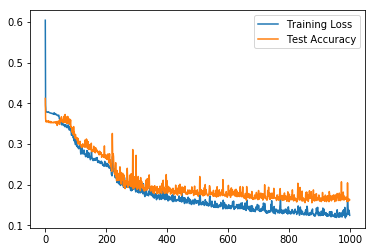

In [63]:
import matplotlib.pyplot as plt
#693/693 [==============================] - 0s 660us/step - loss: 0.0143 - val_loss: 0.0389
l_test = (history.history['val_loss'])
l_train = (history.history['loss'])
l_test = np.sqrt(history.history['val_loss'])
l_train = np.sqrt(history.history['loss'])
plt.plot(l_train, label="Training Loss")
plt.plot(l_test, label="Test Accuracy")
plt.legend()

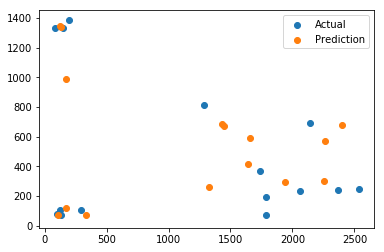

In [64]:
#model.outputs[0]
#m.outputs = 
display = [2560,1440]   
y_pred = model.predict(Input)

start = 5
end = 20
plt.scatter(y[start:end,0]*display[0],y[start:end,1]*display[1],label = "Actual")
plt.scatter(y_pred[start:end,0]*display[0],y_pred[start:end,1]*display[1], label = "Prediction")
plt.legend()

([array([ 19., 109.,  59.,  62., 135., 158.,  62.,  74.,  76.,  17.]),
  array([  8.,  55.,  81.,  75.,  97., 165., 143.,  97.,  43.,   7.])],
 array([-0.08087245,  0.03560325,  0.15207894,  0.26855463,  0.38503033,
         0.50150603,  0.61798173,  0.7344574 ,  0.8509331 ,  0.9674088 ,
         1.0838845 ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

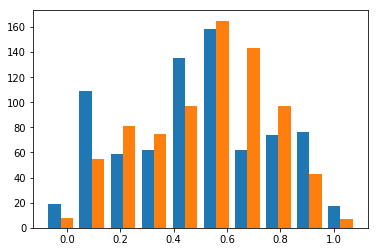

In [65]:
plt.hist(y_pred)

([array([ 75.,  84.,  38.,  82., 118., 117.,  68.,  35.,  86.,  68.]),
  array([ 43.,  75.,  91.,  51.,  73., 111., 119.,  92.,  71.,  45.])],
 array([0.00359975, 0.10314647, 0.2026932 , 0.30223992, 0.40178665,
        0.50133337, 0.6008801 , 0.70042682, 0.79997355, 0.89952027,
        0.999067  ]),
 <a list of 2 Lists of Patches objects>)

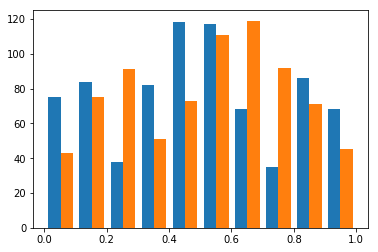

In [24]:
plt.hist(y)

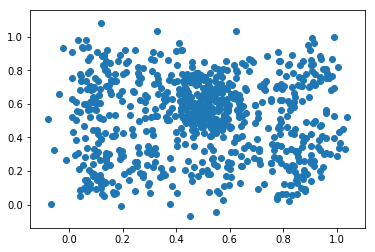

In [66]:
plt.scatter(y_pred[:,0],y_pred[:,1])

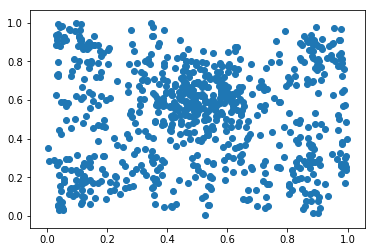

In [50]:
plt.scatter(y[:,0],y[:,1])